In [1]:
import timeit
import matplotlib.pyplot as plt
import pickle
from mnist import MNIST
from time import time

In [2]:
print("Loading dataset....")
mndata = MNIST('../mnist_fashion')
X_train, y_train = mndata.load_training()
X_train = (mndata.process_images_to_numpy(X_train)/255)
X_test, y_test = mndata.load_testing()
X_test = (mndata.process_images_to_numpy(X_test)/255)
print("Done.")

Loading dataset....
Done.


In [3]:
def one_hot_encode(labels):
    y_inp=np.zeros((len(labels),10))
    for ind,val in enumerate(labels):
        y_inp[ind][val]=1
    return y_inp

In [4]:
def batch_gen(st=0,size=20,validate=False):
    st=st%60000
    if validate:
        X=X_test[st:st+size].reshape(-1,28,28,1)
        labels=y_test[st:st+size]
    else:
        X=X_train[st:st+size].reshape(-1,28,28,1)
        labels=y_train[st:st+size]
    y=one_hot_encode(labels)
    return X,y

# Import network, layers and functions

In [5]:
from network import Sequential,layers
from layers import conv2d,max_pool,flatten,dense,dropout
import functions
import numpy as np

# Make Sequential Model

In [17]:
model=Sequential()

In [18]:
model.add(conv2d(input_shape=(28,28,1),num_kernels=32,kernel_size=3,activation=functions.relu))
model.add(max_pool())
model.add(dropout(0.2))
model.add(conv2d(num_kernels=64,kernel_size=3,activation=functions.relu))
model.add(max_pool())
model.add(dropout(0.3))
model.add(conv2d(num_kernels=128,kernel_size=3,activation=functions.relu))
model.add(max_pool())
model.add(dropout(0.4))
model.add(flatten())
model.add(dense(256,activation=functions.relu))
model.add(dropout(0.4))
model.add(dense(10,activation=functions.softmax))

# View Model Summary

In [19]:
model.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Name (type)                     Output Shape             Activation        Param #
input_layer (InputLayer)       (None, 28, 28, 1)          echo             0
__________________________________________________________________________________________
conv2d (conv2d)                (None, 28, 28, 32)         relu             320
__________________________________________________________________________________________
max_pool (max_pool)            (None, 14, 14, 32)         echo             0
__________________________________________________________________________________________
dropout (dropout)              (None, 14, 14, 32)         echo             0
__________________________________________________________________________________________
conv2d (conv2d)                (None, 14, 14, 64)         relu             18496
_______________________________________________________________________

# Compile model with optimizer, loss and lr

In [68]:
model.compile(optimizer=functions.adam,loss=functions.cross_entropy_with_logits,learning_rate=0.001)

In [26]:
model.load_weights("fashion.dump")

# Train model

In [38]:
losses=[]
train_acc=[]

In [36]:
def validate():
    vdsz=2000
    dvme=10000//vdsz
    acc=0
    cross_entropy_loss=0
    for smpl in range(0,10000,vdsz):
        print("\rCalculating Validation acc...",dvme-smpl//vdsz,end='')
        inp,y_inp=batch_gen(smpl,size=vdsz,validate=True)
        logits=model.predict(inp)
        ans=logits.argmax(axis=1)
        cor=y_inp.argmax(axis=1)
        acc+=100*(ans==cor).mean()
        cross_entropy_loss+=model.loss(logits,labels=y_inp).mean()*10
    print("\rValidation Acc: {:.3f} %        Val loss: {:.8f}".format(acc/dvme,cross_entropy_loss/dvme))
    logits=model.predict(inp[:1])

In [55]:
def run():
    st=0
    btsz=128
    acc_tn=0
    _cc=0
    loss_tn=0
    while st<=60000:
        sam_tm=time()
        perc=st/600
        ck=np.random.randint(0,60000-btsz)
        inp,y_inp=batch_gen(ck,size=btsz)
        logits=model.fit(inp,y_inp)
        ans=logits.argmax(axis=1)
        cor=y_inp.argmax(axis=1)
        acc=100*(ans==cor).mean()
        cross_entropy_loss=model.loss(logits=logits,labels=y_inp).mean()*10
        acc_tn+=acc
        _cc+=1
        loss_tn+=cross_entropy_loss
        acc=acc_tn/_cc
        loss_=loss_tn/_cc
        losses.append(loss_)
        train_acc.append(acc)
#         if acc>=98:
#             model.learning_rate=1e-5
#         elif acc>=97:
#             model.learning_rate=1e-5
#         elif acc>=85:
#             model.learning_rate=1e-4
        sam_tm=time()-sam_tm
        rem_sam=(60000-st)/btsz
        eta=int(rem_sam*sam_tm)
        print("\rProgress: {:.2f} %    Acc: {:.3f} %    loss: {:.6f}     Sample time: {:.3f}s    ETA: {}:{}s    .".format(perc,acc,loss_,sam_tm,eta//60,eta%60),end='')
        st+=btsz
    print("")

In [72]:
epochs=3
for epoch in range(epochs):
    print("EPOCH:",epoch+1,'/',epochs)
    st_tm=time()
    run()
    print("Epoch time: {}:{}s".format(int(time()-st_tm)//60,int(time()-st_tm)%60))
    validate()

EPOCH: 1 / 3
Progress: 99.84 %    Acc: 88.433 %    loss: 0.307787     Sample time: 0.569s    ETA: 0:0s    ..
Epoch time: 3:47s
Validation Acc: 88.970 %        Val loss: 0.40082853
EPOCH: 2 / 3
Progress: 99.84 %    Acc: 88.393 %    loss: 0.311728     Sample time: 0.621s    ETA: 0:0s    ..
Epoch time: 4:12s
Validation Acc: 89.110 %        Val loss: 0.42050588
EPOCH: 3 / 3
Progress: 99.84 %    Acc: 88.165 %    loss: 0.313346     Sample time: 0.474s    ETA: 0:0s    ..
Epoch time: 4:1s
Validation Acc: 89.110 %        Val loss: 0.41068720


In [73]:
validate()

Validation Acc: 89.110 %        Val loss: 0.41068720


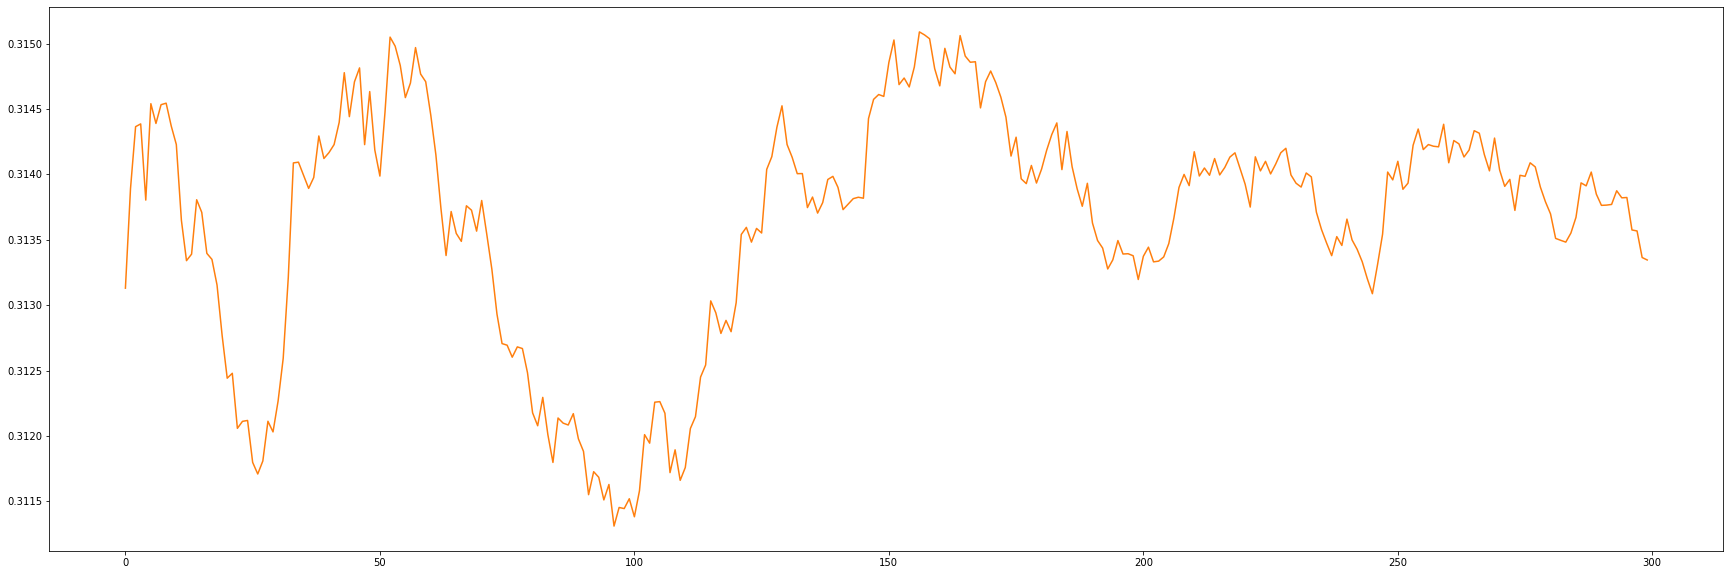

In [74]:
plt.figure(figsize=(30,10))
plt.plot(losses[-300:],color='#ff7f0e')
plt.show()

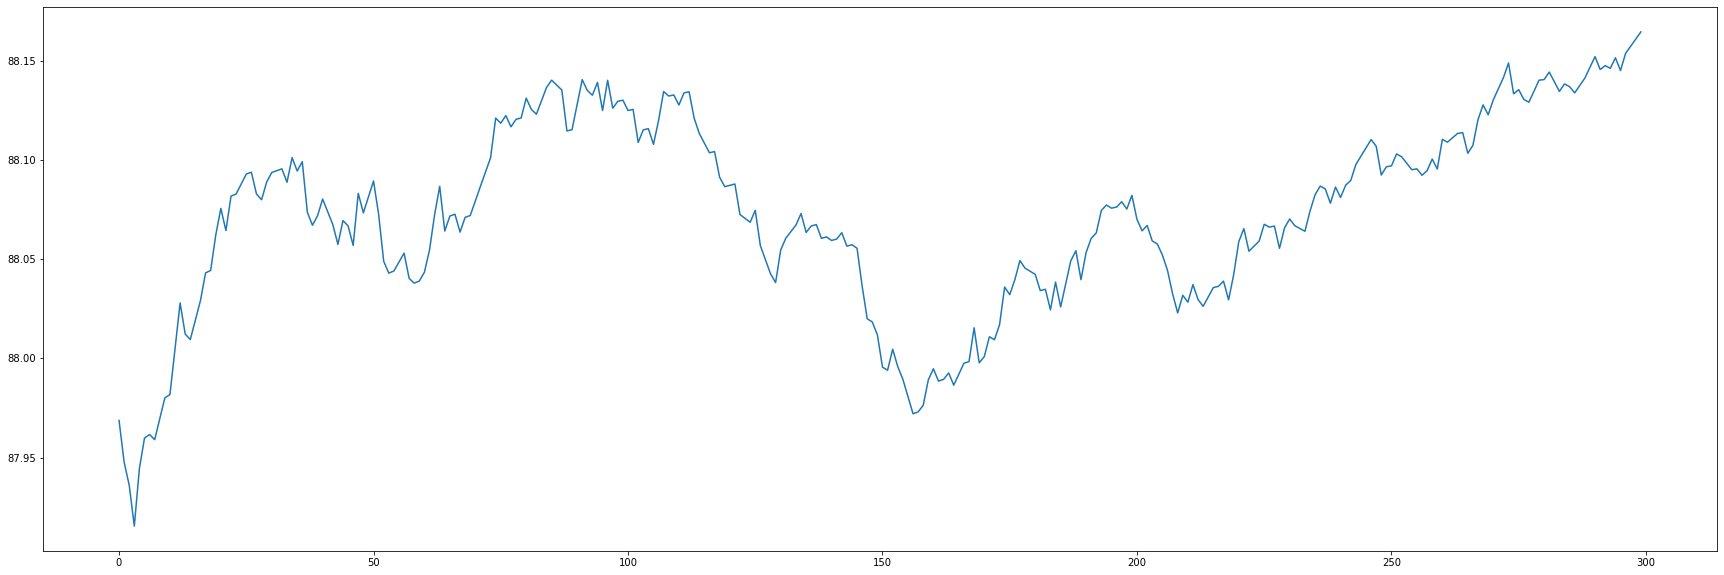

In [75]:
plt.figure(figsize=(30,10))
plt.plot(train_acc[-300:])#,color='#ff7f0e')
plt.show()

In [76]:
model.save_weights("fashion.dump")

In [77]:
LABEL_NAMES = ['t_shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']

Prediction: bag 
Correct:    bag


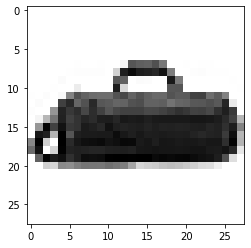

In [91]:
ck=np.random.randint(0,60000-100)
inp,y_inp=batch_gen(ck,size=1)
logits=model.predict(inp)
ans=logits.argmax(axis=1)
cor=y_inp.argmax(axis=1)
print("Prediction:",LABEL_NAMES[ans[0]],"\nCorrect:   ",LABEL_NAMES[cor[0]])
plt.imshow(inp[0].reshape(28,28), cmap='Greys')

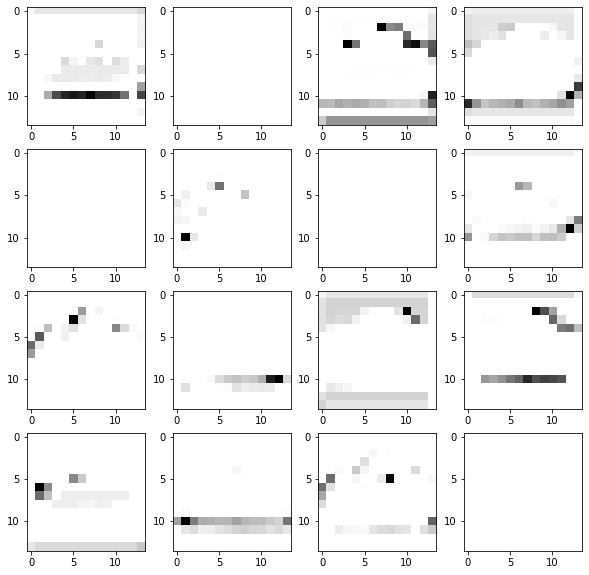

In [92]:
fig, ax = plt.subplots(nrows=4,ncols=4,figsize=[10,10])
fig.patch.set_facecolor('white')
pme=model.sequence[3].z_out.transpose(3,0,1,2)
for i,axi in enumerate(ax.flat):
    axi.imshow(pme[i].reshape(pme.shape[-2:]), cmap='Greys')